
# Part 2 - Multiple Hypothesis Testing with the Diabetes Dataset

## Why do we need to care if we do multiple hypothesis testing?

In Part 1, we have explored comparing 2 groups of data. We were able to say whether they are different from each other with some probability (equal to the p-value obtained).




## Diabetes Dataset Overview

This notebook uses a subset of the **Diabetes dataset** to demonstrate multiple hypothesis testing. We will test several hypotheses about clinical measurements such as glucose levels, body mass index, and age, and then apply corrections to control for Type I errors. This dataset is often referred to as the Pima Indians Diabetes Database, as it originates from a study of diabetes among Pima Indian women in the United States.

The “diabetes” dataset is commonly used in machine learning and statistical modeling for binary classification tasks, particularly for predicting the onset of diabetes. It is publicly available and often used for educational purposes or testing models. Below is a general description of the dataset:

Key Variables (Features):

1. Pregnancies: Number of times the patient has been pregnant.
2. Glucose: Plasma glucose concentration after a 2-hour oral glucose tolerance test.
3. BloodPressure: Diastolic blood pressure (mm Hg).
4. SkinThickness: Triceps skinfold thickness (mm).
5. Insulin: 2-Hour serum insulin (mu U/ml).
6. BMI: Body mass index (weight in kg/(height in m)<sup>2</sup>).
7. DiabetesPedigreeFunction: A function which scores the likelihood of diabetes based on family history (pedigree).
8. Age: Age of the patient (years).
9. Outcome: Binary variable (0 or 1) indicating whether the patient has diabetes (1 = Yes, 0 = No).


## Hypothesis Testing and Errors
In this analysis, we'll test various hypotheses about how these measurements differ between diabetic and non-diabetic individuals. We'll apply both Bonferroni and False Discovery Rate (FDR) corrections to account for multiple testing and reduce Type I errors.

First, let's discuss some theory to understand what are Type I and II errors, and why do we need to correct for multiple testing.



### Type I Error (False Positive)

A **Type I error** occurs when we reject the null hypothesis when it is actually true, leading to a false positive conclusion.

#### Probability of Type I Error
The probability of making a Type I error is determined by the **significance level &alpha;**, which is often set to 0.05. If the p-value is below &alpha;, we reject the null hypothesis. This means that for any given test, there is a 5% chance of rejecting the null hypothesis incorrectly (i.e., making a Type I error).

**Example**: If you conduct a test at &alpha; = 0.05, there's a 5% chance that the result could be a false positive, even if the null hypothesis is true.

### Type II Error (False Negative)

A **Type II error** occurs when we fail to reject the null hypothesis even though it is false. In other words, a Type II error results in a **false negative** conclusion, where we miss detecting an effect or difference that actually exists.

#### Probability of Type II Error
The probability of making a Type II error is denoted by &beta;. The complement of &beta;, which is 1 - &beta;, is known as the **power** of the test. The power of a test is the probability of correctly rejecting the null hypothesis when it is false (i.e., detecting an effect that actually exists). Determining the value of &beta; is beyond the scope of this introduction.

**Example**: If &beta; = 0.2, this means there is a 20% chance of making a Type II error (failing to reject the null hypothesis when it is false), and the power of the test is $1 - \beta = 0.8$, meaning there's an 80% chance of correctly detecting an effect.

#### Factors Influencing Type II Error
Several factors influence the likelihood of making a Type II error:
- **Sample Size**: A larger sample size reduces the likelihood of a Type II error and increases the power of the test.
- **Effect Size**: Larger effect sizes (the magnitude of the difference between the null and alternative hypothesis) are easier to detect, reducing the probability of a Type II error.
- **Significance Level (&alpha;)**: A lower significance level (stricter threshold) increases the chance of a Type II error because we are less likely to reject the null hypothesis.

### Tradeoff Between Type I and Type II Errors

There is an inherent tradeoff between Type I and Type II errors. When designing a hypothesis test, reducing the probability of one type of error typically increases the probability of the other.

If you aim for a very low probability of Type I error (strict &alpha;), the test becomes more conservative, leading to a higher probability of Type II errors (less power to detect effects). Conversely, if you aim to reduce Type II errors (increase the power), the test becomes more lenient, increasing the risk of Type I errors.

#### Optimal Balance
The goal in hypothesis testing is to find an optimal balance between Type I and Type II errors. This often depends on the context and the consequences of each type of error:
- **When Type I error is more costly** (e.g., in medical testing where false positives lead to unnecessary treatments), a lower &alpha; may be preferred.
- **When Type II error is more costly** (e.g., a fault test in a lift where a false negative will put users in danger), a higher &alpha; or a more powerful test may be preferred.

Ultimately, it is you who must decide the acceptable levels of both types of errors based on the specific context and the consequences of each error.

### Type I Error Inflation in Multiple Testing
When you perform multiple hypothesis tests, the probability of making at least one Type I error across all tests increases. This is because each test carries its own chance of error, and the more tests you conduct, the more likely you are to encounter a false positive.

#### Overall probability of at least one Type I error
If you perform *m* tests, the overall probability of making at least one Type I error is given by:

$$P(\text{at least one Type I error}) = 1 - (1 - \alpha)^m$$

where *m* is the number of tests and &alpha; is the significance level.

**Example**: For 10 tests at $\alpha = 0.05$:

$$P(\text{at least one Type I error}) = 1 - (1 - 0.05)^{10} \approx 0.401$$

This means there's about a 40% chance of making at least one false positive when conducting 10 tests with a significance level of 0.05.

### Bonferroni Correction
The **Bonferroni correction** adjusts the significance level to control the overall probability of making Type I errors when performing multiple tests. It divides the significance level by the number of tests to create a stricter threshold for each individual test.

For *m* tests, the new significance level becomes:
$$\alpha_{\text{corrected}} = \frac{\alpha}{m}$$

**Example**: If you conduct 10 tests at $\alpha = 0.05$, the Bonferroni correction adjusts the threshold for each test to $\alpha_{\text{corrected}} = 0.05 / 10 = 0.005$. This reduces the chance of making a Type I error in any given test and controls the overall error rate across all tests.

### False Discovery Rate (FDR) Correction
The **False Discovery Rate (FDR)** correction provides a more flexible approach to controlling errors in multiple testing scenarios. Instead of controlling the probability of making any false positives (like the Bonferroni correction), FDR controls the expected proportion of false positives among the rejected hypotheses. This is particularly useful when conducting a large number of tests and where some false positives are tolerable, as long as their rate is controlled.

The FDR is commonly controlled using the **Benjamini-Hochberg procedure**. The steps for the procedure are as follows:

1. Rank all *p*-values in ascending order: *p<sub>1</sub>, p<sub>2</sub>, ... , p<sub>m</sub>* where *m* is the number of tests.
2. For a chosen FDR level *q*, find the largest *k* such that:
$$p_k \leq \frac{k}{m} \cdot q$$
3. Reject all hypotheses with *p*-values less than or equal to *p<sub>k</sub>*.

**Example**: If you perform 10 tests and choose an FDR level of $ q = 0.05 $, you rank the *p*-values and apply the above formula to determine the threshold for rejecting null hypotheses while controlling the FDR at 5%. This allows you to reject some hypotheses while ensuring that the proportion of false positives among them remains low.

FDR correction is generally less conservative than Bonferroni, making it more powerful in situations where multiple comparisons are being made and some false positives are acceptable.

### When to Use Bonferroni vs. FDR:

When to Use Bonferroni:

1. Small Number of Hypotheses: Bonferroni is suitable when you’re conducting only a small number of hypothesis tests (e.g., fewer than 10). In these cases, the conservativeness of Bonferroni is less of a burden, and it ensures a low risk of false positives.
2. Strong Control of Type I Errors: If you need to be extremely cautious about making false positives (e.g., in clinical trials or regulatory decision-making), Bonferroni is ideal. The focus is on ensuring that no false positives slip through, even if it means missing some true effects (i.e., increasing Type II errors).
3. Confirmatory Research: When you’re in the phase of testing well-established hypotheses, where the cost of a false positive is high, Bonferroni is preferred. For example, in medical research, where a false conclusion about a drug’s efficacy could have serious consequences, Bonferroni offers a stringent level of control.

When to Use FDR (False Discovery Rate):

1. Large Number of Hypotheses: FDR is better suited when dealing with a large number of hypotheses, such as in genomic studies, social science research, or exploratory analyses with many comparisons. In such cases, Bonferroni might be too conservative and lead to many false negatives, missing potentially important discoveries.
2. Exploratory Research: If you’re exploring many possible relationships, and your goal is to identify several potential leads while tolerating a certain proportion of false positives (e.g., identifying genes related to a disease), FDR is more appropriate. It balances discovering true effects with controlling the rate of false positives.
3. When Some False Positives Are Acceptable: In situations where false positives are less critical, and you’re willing to tolerate some in exchange for identifying more true positives, FDR is a more practical choice. This is often the case in preliminary research or in fields where follow-up studies can later validate the findings.

## Data Analysis of the diabetes dataset

### Data visualisation

As a first step of data analysis, let's visualise it. We want to test various hypotheses about how these measurements differ between diabetic and non-diabetic individuals.

In [27]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.multitest import multipletests

from scipy.stats import shapiro, mannwhitneyu, ttest_ind
#from statsmodels.stats.multitest import multipletests

Loading and initial processing of data:

In [33]:
# Load the dataset
data = pd.read_csv('diabetes.csv')

# Replace 0 with NaN for relevant columns (we assume that 0 is invalid for certain variables)
# We don't consider 0 as valid for 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', and 'BMI'
columns_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
data[columns_with_zeros] = data[columns_with_zeros].replace(0, np.nan)

# Remove incomplete data rows
data = data.dropna()

# Separate the data by the Outcome column
diabetes_0 = data[data['Outcome'] == 0]  # No diabetes group
diabetes_1 = data[data['Outcome'] == 1]  # Diabetes group

# List of variables to plot (excluding the column, 'Outcome')
variables = data.columns[:-1]

diabetes_1

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1
6,3,78.0,50.0,32.0,88.0,31.0,0.248,26,1
8,2,197.0,70.0,45.0,543.0,30.5,0.158,53,1
13,1,189.0,60.0,23.0,846.0,30.1,0.398,59,1
14,5,166.0,72.0,19.0,175.0,25.8,0.587,51,1
16,0,118.0,84.0,47.0,230.0,45.8,0.551,31,1
19,1,115.0,70.0,30.0,96.0,34.6,0.529,32,1
24,11,143.0,94.0,33.0,146.0,36.6,0.254,51,1
25,10,125.0,70.0,26.0,115.0,31.1,0.205,41,1
31,3,158.0,76.0,36.0,245.0,31.6,0.851,28,1


Plot histograms for each variable, grouped by Outcome

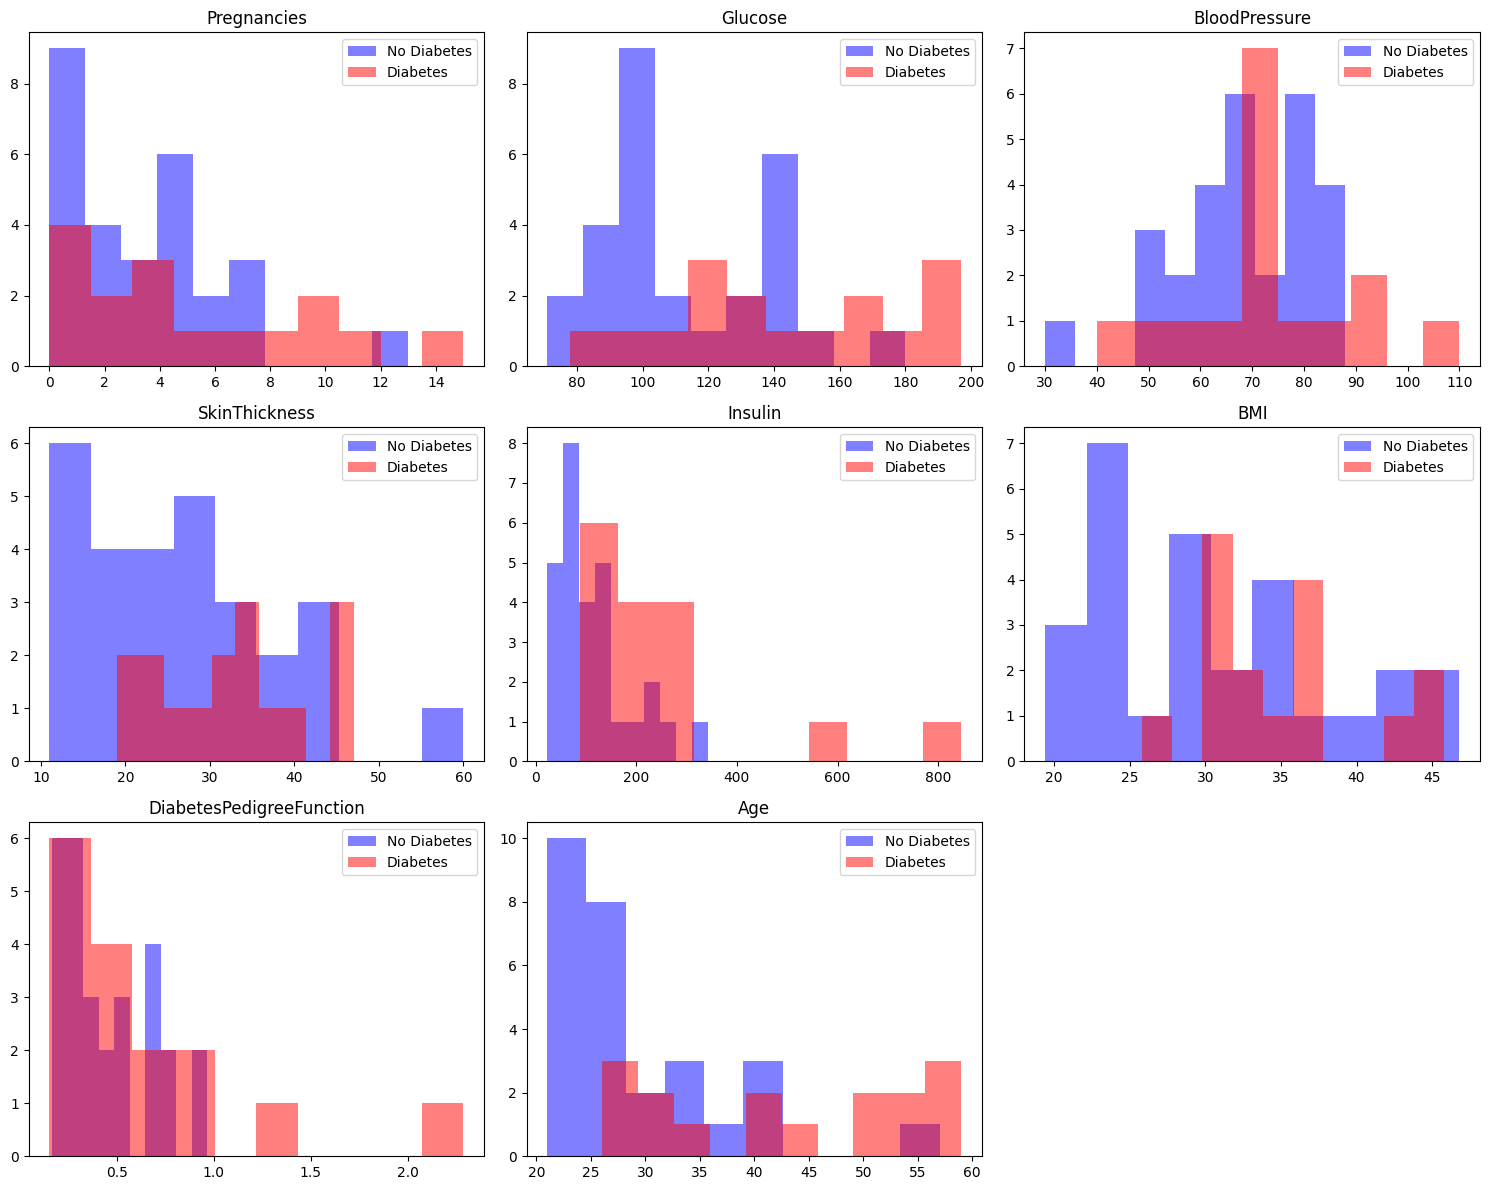

In [34]:
plt.figure(figsize=(15, 12))  # Create a figure for multiple subplots
for i, var in enumerate(variables):
    plt.subplot(3, 3, i+1)  # Create a 3x3 grid of subplots
    plt.hist(diabetes_0[var], bins=10, alpha=0.5, label='No Diabetes', color='blue')  # Plot histogram for no diabetes
    plt.hist(diabetes_1[var], bins=10, alpha=0.5, label='Diabetes', color='red')  # Plot histogram for diabetes
    plt.title(var)  # Set the title to the variable name
    plt.legend()  # Add a legend to distinguish the groups

# Display the plots
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

We can see that for all variables the distributions for people with and without diabetes *look* different. We now want to investigate if the differences are statistically significant.

### Testing if the data is nomally distributed

We want first to check if the data is normally/gaussian distributed, because that will determine if we can use the t-test or not. Some of the histograms above look normally distributed, others less so, but we should use the Shapiro-Wilk test to verify.

In [35]:
def clean_shapiro(col):
    '''Remove NaN from col, applies the Shapiro-Wilk test,
    and returns the p-value.
    Assumes that col is a column of a pandas dataframe.'''
    
    clean=col.dropna()
    return shapiro(clean).pvalue

In [36]:
diabetes_0[variables].apply(clean_shapiro)

Pregnancies                 0.002382
Glucose                     0.068130
BloodPressure               0.130857
SkinThickness               0.112857
Insulin                     0.005142
BMI                         0.104458
DiabetesPedigreeFunction    0.006678
Age                         0.000245
dtype: float64

The p-value is lower than 0.05 for variables: Pregnancies, Insulin, DiabetesPedigreeFunction, Age, so we reject the null hypothesis for these variables, and infer that the distributions are not normal for these variables.

How about individuals with diabetes?

In [23]:
diabetes_1[variables].apply(clean_shapiro)

Pregnancies                 0.062416
Glucose                     0.737311
BloodPressure               0.534959
SkinThickness               0.533423
Insulin                     0.000231
BMI                         0.239117
DiabetesPedigreeFunction    0.000544
Age                         0.051213
dtype: float64

The p-value is lower than 0.05 for variables: Insulin, DiabetesPedigreeFunction, so we reject the null hypothesis for these variables, and infer that the distributions are not normal for these variables.

As some of variables are not distributed normally, we cannot use the t-test, and will use Mann-Whitney U test. Therefore, we do not need to check for equality of variance between pairs of variables.

### Hypotheses for Variables in the Diabetes Dataset

1. Pregnancies:
   - H<sub>0</sub>: The distribution of number of pregnancies is the same for people with and without diabetes.
   - H<sub>A</sub>: The distribution of number of pregnancies is different for people with and without diabetes.

2. Glucose:
   - H<sub>0</sub>: The distribution of glucose levels are the same for people with and without diabetes.
   - H<sub>A</sub>: The distribution of glucose levels are different for people with and without diabetes.

3. BloodPressure:
   - H<sub>0</sub>: The distribution of blood pressure is the same for people with and without diabetes.
   - H<sub>A</sub>: The distribution of blood pressure is different for people with and without diabetes.

4. SkinThickness:
   - H<sub>0</sub>: The distribution of skin thickness is the same for people with and without diabetes.
   - H<sub>A</sub>: The distribution of skin thickness is different for people with and without diabetes.

5. Insulin:
   - H<sub>0</sub>: The distribution of insulin levels are the same for people with and without diabetes.
   - H<sub>A</sub>: The distribution of insulin levels are different for people with and without diabetes.

6. BMI:
   - H<sub>0</sub>: The distribution of BMI is the same for people with and without diabetes.
   - H<sub>A</sub>: The distribution of BMI is different for people with and without diabetes.

7. DiabetesPedigreeFunction:
   - H<sub>0</sub>: The distribution of diabetes pedigree function is the same for people with and without diabetes.
   - H<sub>A</sub>: The distribution of diabetes pedigree function is different for people with and without diabetes.

8. Age:
   - H<sub>0</sub>: The distribution of age is the same for people with and without diabetes.
   - H<sub>A</sub>: The distribution of age is different for people with and without diabetes.

In [37]:
# Store p-values from Mann-Whitney U tests
p_values = []

# Perform Mann-Whitney U test for each variable
for var in variables:  # Exclude the Outcome column
    group_0 = diabetes_0[var].dropna()
    group_1 = diabetes_1[var].dropna()

    # Perform the test and store the p-value
    _, p_value = mannwhitneyu(group_0, group_1)
    p_values.append(p_value)

# Bonferroni correction
bonferroni_corrected = multipletests(p_values, alpha=0.05, method='bonferroni')[1]

# FDR correction (Benjamini-Hochberg)
fdr_corrected = multipletests(p_values, alpha=0.05, method='fdr_bh')[1]

# Display the original p-values, Bonferroni-corrected, and FDR-corrected p-values
print(f'{"Variable":<26} {"p-value":<14} {"Bonferroni":<15} {"FDR":<14}')
for i in range(len(variables)):
    print(f'{variables[i]:<26} {p_values[i]:<14.8f} {bonferroni_corrected[i]:<15.8f} {fdr_corrected[i]:<14.8f}')

Variable                   p-value        Bonferroni      FDR           
Pregnancies                0.32533470     1.00000000      0.41782600    
Glucose                    0.00700137     0.05601092      0.01867031    
BloodPressure              0.36559775     1.00000000      0.41782600    
SkinThickness              0.06529313     0.52234501      0.10446900    
Insulin                    0.00219392     0.01755139      0.00877569    
BMI                        0.03277272     0.26218178      0.06554544    
DiabetesPedigreeFunction   0.59988578     1.00000000      0.59988578    
Age                        0.00018397     0.00147173      0.00147173    


By carefully looking at the table, we can see that:
- The p-value for the comparison of glucose levels between the diabetic and non-diabetic populations increases over the 0.05 treshold after the Bonferroni correction, but not FDR correction
-  The p-value for the comparison of BMI between the diabetic and non-diabetic populations p-value increases over the 0.05 treshold after the Bonferroni correction, and the FDR correction.

We can also visualise these results:

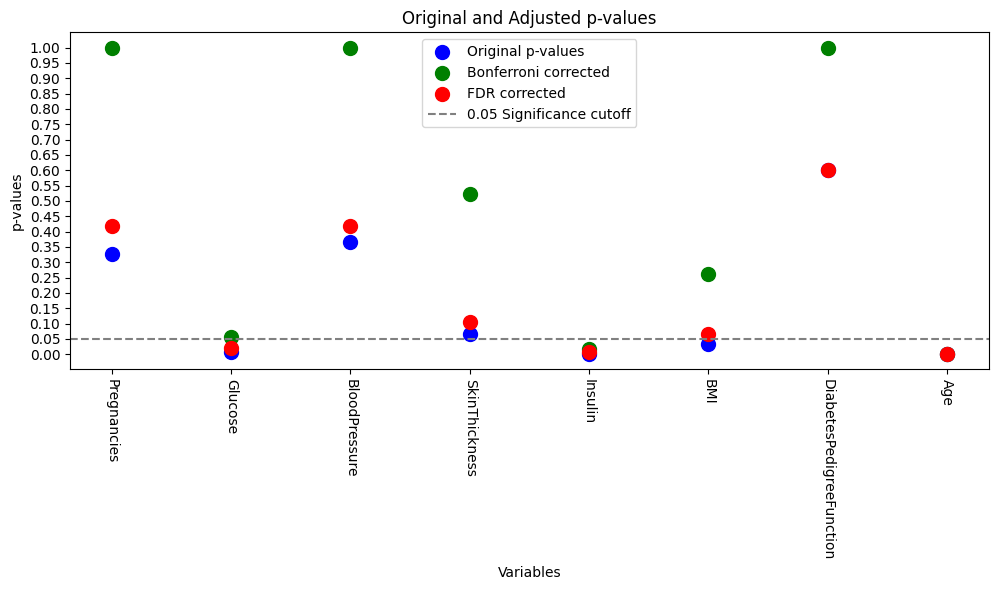

In [40]:
# Plotting the results
variables = np.array(variables)
plt.figure(figsize=(10, 6))

# Plot original p-values
plt.scatter(variables, p_values, color='blue', label='Original p-values', s=100)

# Plot Bonferroni corrected p-values
plt.scatter(variables, bonferroni_corrected, color='green', label='Bonferroni corrected', s=100)

# Plot FDR corrected p-values
plt.scatter(variables, fdr_corrected, color='red', label='FDR corrected', s=100)

# Draw the significance cutoff at p = 0.05
plt.axhline(y=0.05, color='gray', linestyle='--', label='0.05 Significance cutoff')

plt.xlabel('Variables')
plt.ylabel('p-values')
plt.title('Original and Adjusted p-values')
plt.legend(loc=9)
plt.xticks(rotation=270)
plt.tight_layout()
plt.yticks(np.arange(0, 1.05, 0.05))  # Set x-axis ticks every 0.05

# Show the plot
plt.show()

### Conclusion

Based on the statistical tests performed using the **Mann-Whitney U test**, we found significant differences in the distributions between people with and without diabetes for some of the variables considered. As this was just an exploratory exercise, we decide to use the FDR-corrected results. Below is a summary of the findings:

1. **Glucose**: The distribution of glucose levels is significantly different between people with and without diabetes.

2. **Insulin**: The distribution of insulin levels is significantly different between people with and without diabetes.

3. **Age**: The distribution of age is significantly different between people with and without diabetes.

For all other variables considered in this analysis we could not find a significant difference. That does not mean the difference does not exist - perhaps it is just that our data is not sufficient to show it.

### Practice - Multiple comparisons using the Iris dataset

Using the same dataset as for practice in part 1, you will now do some multiple hypothesis testing.

The dataset contains 150 observations of iris flowers, with three different species: Setosa, Versicolor, and Virginica. Each observation is described by the following four numerical features:

1. Sepal.Length: The length of the sepals in centimeters.
2. Sepal.Width: The width of the sepals in centimeters.
3. Petal.Length: The length of the petals in centimeters.
4. Petal.Width: The width of the petals in centimeters.

![Iris flower and variables](image.png)

Additionally, a fifth variable, Species, represents the species of the iris flower (categorical with three levels: Setosa, Versicolor, and Virginica). The dataset is stored in the *iris.csv* file.

The primary goal of this exercise is to test difference in sepal lenght, sepal width, petal length, and petal width between two species of your choice and apply Bonferroni and FDR corrections to the obtained p-values.